In [1]:
import sys
import os
from warnings import simplefilter

# Add the Functions folder to your path
sys.path.append(os.path.abspath("/Users/alexandra/Desktop/EG-CLR/Functions"))

# Now import your functions
from QC_functions import *
from CLR_functions import *
from Verfication_functions import *
from Plot_functions import *

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


In [2]:
# read CRISPRi data
CRISPRi_data = pd.read_excel('/Users/alexandra/Desktop/Data/CRISPRiFlowFISH/41588_2019_538_MOESM3_ESM.xlsx',
                             sheet_name='Supplementary Table 3a', 
                             skiprows=0,
                             header=1)

# select columns
CRISPRi_data_sub= CRISPRi_data[['chr', 'start', 'end', 'Element name', 'Gene', 'Adjusted p-value', 'Significant', 'Fraction change in gene expr','Power to detect 25% effects','Valid E-G connection']]
print(" there are ", CRISPRi_data_sub.shape[0], " CRISPRi elements in the data set")

 there are  4914  CRISPRi elements in the data set


/opt/anaconda3/envs/k562_analysis/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/opt/anaconda3/envs/k562_analysis/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [ ]:
def load_CRISPRi_by_gene(CRISPRi_data):

In [3]:
# select valid elements
CRISPRi_data_validated = CRISPRi_data_sub[CRISPRi_data_sub['Valid E-G connection'] == True].copy()
print(" there are ", CRISPRi_data_validated.shape[0], " valid CRISPRi elements in the data set")

 there are  4818  valid CRISPRi elements in the data set


In [4]:
# select chr
CRISPRi_data_validated_ChrX = CRISPRi_data_validated[CRISPRi_data_validated["chr"] == 'chrX']

# select gene 
CRISPRi_data_validated_ChrX_GATA1 = CRISPRi_data_validated_ChrX[CRISPRi_data_validated_ChrX["Gene"] == "GATA1"]


In [7]:
# load adata_gem for distance 
mdata = mu.read("/Volumes/G-DRIVE mobile USB-C/Single-cell_data/K562/10x/ISSAACC-seq_generated/hg19_10xCloud_aligned_data/processed_data/multiome_data_5.25.25.h5mu")

adata_gem = mdata['rna']
adata_atac = mdata['atac']

adata_gem = assign_chr('/Volumes/G-DRIVE mobile USB-C/Single-cell_data/K562/10x/ISSAACC-seq_generated/hg19_10xCloud_aligned_data/filtered_feature_bc_matrix/features.tsv.gz', adata_gem)

# load MI data
MI_Matrix_chrx = load_matrix("/Users/alexandra/Desktop/EG-CLR/Test/results/ChrX_51Genes_S1_Binarized_10K_K562_5.28.25.pkl")
MI_Matrix_chrx_2 = load_matrix("/Users/alexandra/Desktop/EG-CLR/Test/results/ChrX_51Genes_S2_Binarized_10K_K562_5.28.25.pkl")

# adjust to distance
MI_Matrix_adjusted = distance_adjustment(MI_Matrix_chrx, adata_gem.var['Start'])
MI_Matrix_adjusted_2 = distance_adjustment(MI_Matrix_chrx_2, adata_gem.var['Start'])


# compute CLR values
CLR_matrix_chrx_z = CLR_Matrix(MI_Matrix_adjusted)
CLR_matrix_chrx_2_z = CLR_Matrix(MI_Matrix_adjusted_2)

# assign z threhold
CLR_matrix_chrx_z_0 = z_score_filter(CLR_matrix_chrx_z, zthre=0)
CLR_matrix_chrx_2_z_0 = z_score_filter(CLR_matrix_chrx_2_z, zthre=0)

# intersection of CLR matrixes
CLR_matrix_intersection = intersection_CLR(CLR_matrix_chrx_z_0, CLR_matrix_chrx_2_z_0)

/opt/anaconda3/envs/k562_analysis/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/opt/anaconda3/envs/k562_analysis/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)
/Users/alexandra/Desktop/EG-CLR/Functions/CLR_functions.py:432: FutureWarning: ChainedAssignmentError: behavio

In [8]:
# covert matrix prediction to list 
CLR_matrix_intersection_df = convert_matrix_to_df(CLR_matrix_intersection)

# add distance to tss for each element
CLR_matrix_intersection_df_tss = calculate_tss(CLR_matrix_intersection_df, adata_gem)

# isolate specific gene 
CLR_matrix_intersection_df_tss_GATA1 = CLR_matrix_intersection_df_tss[CLR_matrix_intersection_df_tss["Gene"] == "GATA1"]

In [10]:
overlap_CRISPRi = CRISPRi_comparison(CRISPRi_data_validated_ChrX_GATA1[['chr', 'start', 'end']],CLR_matrix_intersection_df_tss_GATA1[['Chr_peak', 'Start_peak', 'End_peak']] )
overlap_CRISPRi = overlap_CRISPRi.rename(columns={'chr': 'Chromosome','start':'Start', 'end': 'End'})
overlap_CRISPRi

,Chromosome,Start,End
0,chrX,46655945,46656445
1,chrX,46696085,46696605
2,chrX,46696685,46697185
3,chrX,46837945,46838445
4,chrX,46907325,46907845
...,...,...,...
176,chrX,49948505,49949145
177,chrX,49962985,49963545
178,chrX,49969065,49969605
179,chrX,50322885,50323405


In [15]:
CLR_matrix_intersection_df_tss_GATA1 = CLR_matrix_intersection_df_tss_GATA1.drop(columns=['Start', "End"])
CLR_matrix_intersection_df_tss_GATA1 = CLR_matrix_intersection_df_tss_GATA1.rename(columns={'Chr_peak': 'Chromosome',
                                                                                            'Start_peak': 'Start',
                                                                                            'End_peak': 'End'})
CLR_matrix_intersection_df_tss_GATA1

,Element,Value,Gene,Chromosome,Start,End,distance_to_tss
17757,chrX:10014956-10015881,0.008848,GATA1,chrX,10014956,10015881,33622075
17758,chrX:100306385-100307310,0.159307,GATA1,chrX,100306385,100307310,101815069
17759,chrX:100311865-100312771,0.489267,GATA1,chrX,100311865,100312771,101823279
17760,chrX:100352594-100353501,0.374048,GATA1,chrX,100352594,100353501,101884373
17761,chrX:100652565-100653461,0.301043,GATA1,chrX,100652565,100653461,102334324
...,...,...,...,...,...,...,...
19054,chrX:97828388-97829264,0.637095,GATA1,chrX,97828388,97829264,98098049
19055,chrX:99702485-99703370,0.131270,GATA1,chrX,99702485,99703370,100909199
19056,chrX:99929553-99930415,0.103825,GATA1,chrX,99929553,99930415,101249789
19057,chrX:99940434-99941332,0.691073,GATA1,chrX,99940434,99941332,101266129


In [21]:
over_CRISPRi_value = overlap_CRISPRi.merge(CRISPRi_data_validated_ChrX_GATA1, 
                                            how = "left",
                                            left_on = ['Chromosome', 'Start', 'End'],
                                            right_on = ['chr', 'start', 'end']).drop(columns = ['chr','start','end'])

In [35]:
over_CRISPRi_value

,Chromosome,Start,End,Element name,Gene,Adjusted p-value,Significant,Fraction change in gene expr,Power to detect 25% effects,Valid E-G connection,Value
0,chrX,46655945,46656445,intergenic|chrX:46655945-46656445,GATA1,0.966121,False,0.002614,0.999975,True,1.168966
1,chrX,46696085,46696605,promoter|chrX:46696085-46696605,GATA1,0.966121,False,-0.021725,1.000000,True,0.565837
2,chrX,46696685,46697185,promoter|chrX:46696685-46697185,GATA1,0.966121,False,0.004184,1.000000,True,0.565837
3,chrX,46837945,46838445,genic|chrX:46837945-46838445,GATA1,0.527542,False,-0.066802,1.000000,True,0.340284
4,chrX,46907325,46907845,genic|chrX:46907325-46907845,GATA1,0.966121,False,-0.046804,1.000000,True,1.062687
...,...,...,...,...,...,...,...,...,...,...,...
176,chrX,49948505,49949145,intergenic|chrX:49948505-49949145,GATA1,0.966121,False,-0.023027,1.000000,True,6.577656
177,chrX,49962985,49963545,genic|chrX:49962985-49963545,GATA1,0.527542,False,0.032671,0.999993,True,6.350372
178,chrX,49969065,49969605,intergenic|chrX:49969065-49969605,GATA1,0.903240,False,-0.043662,1.000000,True,2.997658
179,chrX,50322885,50323405,intergenic|chrX:50322885-50323405,GATA1,0.858038,False,0.019672,0.999982,True,3.067805


In [61]:
sif_list = []

for _, row_a in over_CRISPRi_value.iterrows():
    chr_a, start_a, end_a = row_a['Chromosome'], row_a['Start'], row_a['End']
    
    # Find overlapping rows in df_b
    overlaps = CLR_matrix_intersection_df_tss_GATA1[
        (CLR_matrix_intersection_df_tss_GATA1['Chromosome'] == chr_a) &
        (CLR_matrix_intersection_df_tss_GATA1['Start'] <= end_a) &
        (CLR_matrix_intersection_df_tss_GATA1['End'] >= start_a)
    ]    

    # Take the average of al matches
    sif_val = overlaps['Value'].values.mean() if not overlaps.empty else None
    sif_list.append(sif_val)

# Add new column to df_a
over_CRISPRi_value['Value'] = sif_list

In [63]:
over_CRISPRi_value

,Chromosome,Start,End,Element name,Gene,Adjusted p-value,Significant,Fraction change in gene expr,Power to detect 25% effects,Valid E-G connection,Value
0,chrX,46655945,46656445,intergenic|chrX:46655945-46656445,GATA1,0.966121,False,0.002614,0.999975,True,1.168966
1,chrX,46696085,46696605,promoter|chrX:46696085-46696605,GATA1,0.966121,False,-0.021725,1.000000,True,0.565837
2,chrX,46696685,46697185,promoter|chrX:46696685-46697185,GATA1,0.966121,False,0.004184,1.000000,True,0.565837
3,chrX,46837945,46838445,genic|chrX:46837945-46838445,GATA1,0.527542,False,-0.066802,1.000000,True,0.340284
4,chrX,46907325,46907845,genic|chrX:46907325-46907845,GATA1,0.966121,False,-0.046804,1.000000,True,1.062687
...,...,...,...,...,...,...,...,...,...,...,...
176,chrX,49948505,49949145,intergenic|chrX:49948505-49949145,GATA1,0.966121,False,-0.023027,1.000000,True,6.577656
177,chrX,49962985,49963545,genic|chrX:49962985-49963545,GATA1,0.527542,False,0.032671,0.999993,True,6.350372
178,chrX,49969065,49969605,intergenic|chrX:49969065-49969605,GATA1,0.903240,False,-0.043662,1.000000,True,2.997658
179,chrX,50322885,50323405,intergenic|chrX:50322885-50323405,GATA1,0.858038,False,0.019672,0.999982,True,3.067805


In [50]:
over_CRISPRi_value_True = over_CRISPRi_value[over_CRISPRi_value['Significant'] == True].copy()
print(" there are ", over_CRISPRi_value_True.shape[0], " valid and significant CRISPRi elements in the data set")

 there are  7  valid and significant CRISPRi elements in the data set


In [51]:
print("Max CLR value is ", over_CRISPRi_value["Value"].max(), " Min CLR value is ", over_CRISPRi_value["Value"].min(), " Ave CLR value is ",over_CRISPRi_value["Value"].mean())

Max CLR value is  11.932596939479634  Min CLR value is  0.020207562727344565  Ave CLR value is  4.384910621637627


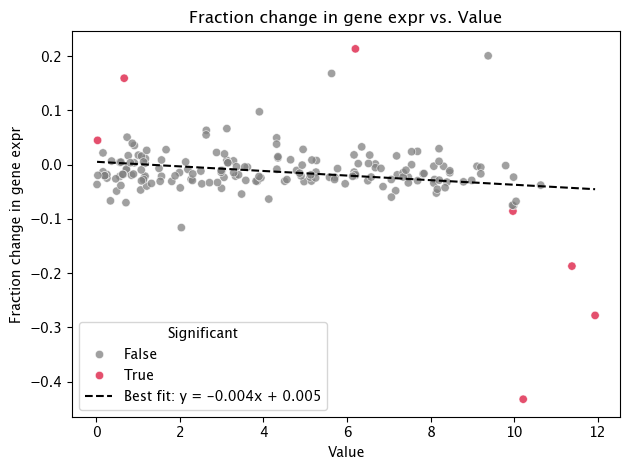

In [52]:
plot_values(over_CRISPRi_value, x_col="Value", y_col="Fraction change in gene expr", hue_col="Significant", line_fit=True)

In [29]:
adata_gem.var.loc["GATA1"]

gene_ids                 ENSG00000102145.13_2
feature_types                 Gene Expression
mt                                      False
ribo                                    False
hb                                      False
n_cells_by_counts                        6958
mean_counts                          1.644348
log1p_mean_counts                    0.972425
pct_dropout_by_counts               37.383009
total_counts                          18272.0
log1p_total_counts                    9.81318
n_cells                                  6676
Chromosome                               chrX
Start                                48644961
End                                  48644981
Gene                                    GATA1
Name: GATA1, dtype: object

In [114]:

over_CRISPRi_value["distance_to_tss"] = ((over_CRISPRi_value["Start"] + over_CRISPRi_value["End"]) // 2  
                                            - (48644961+ 48644981// 2)).abs()


In [115]:
over_CRISPRi_value

,Chromosome,Start,End,Element name,Gene,Adjusted p-value,Significant,Fraction change in gene expr,Power to detect 25% effects,Valid E-G connection,Value,distance_to_tss
0,chrX,46655945,46656445,intergenic|chrX:46655945-46656445,GATA1,0.966121,False,0.002614,0.999975,True,1.168966,26311256
1,chrX,46696085,46696605,promoter|chrX:46696085-46696605,GATA1,0.966121,False,-0.021725,1.000000,True,0.565837,26271106
2,chrX,46696685,46697185,promoter|chrX:46696685-46697185,GATA1,0.966121,False,0.004184,1.000000,True,0.565837,26270516
3,chrX,46837945,46838445,genic|chrX:46837945-46838445,GATA1,0.527542,False,-0.066802,1.000000,True,0.340284,26129256
4,chrX,46907325,46907845,genic|chrX:46907325-46907845,GATA1,0.966121,False,-0.046804,1.000000,True,1.062687,26059866
...,...,...,...,...,...,...,...,...,...,...,...,...
176,chrX,49948505,49949145,intergenic|chrX:49948505-49949145,GATA1,0.966121,False,-0.023027,1.000000,True,6.577656,23018626
177,chrX,49962985,49963545,genic|chrX:49962985-49963545,GATA1,0.527542,False,0.032671,0.999993,True,6.350372,23004186
178,chrX,49969065,49969605,intergenic|chrX:49969065-49969605,GATA1,0.903240,False,-0.043662,1.000000,True,2.997658,22998116
179,chrX,50322885,50323405,intergenic|chrX:50322885-50323405,GATA1,0.858038,False,0.019672,0.999982,True,3.067805,22644306


In [116]:
from sklearn.metrics import roc_auc_score, average_precision_score

# Assuming your DataFrame is called df
y_true = over_CRISPRi_value['Significant']       # Boolean ground truth: True for positive, False for negative
y_scores = over_CRISPRi_value['Value']           # Predicted scores

# Compute AUROC
auroc = roc_auc_score(y_true, y_scores)

# Compute AUPR
aupr = average_precision_score(y_true, y_scores)

print(f"AUROC: {auroc:.4f}")
print(f"AUPR: {aupr:.4f}")

AUROC: 0.6823
AUPR: 0.4874


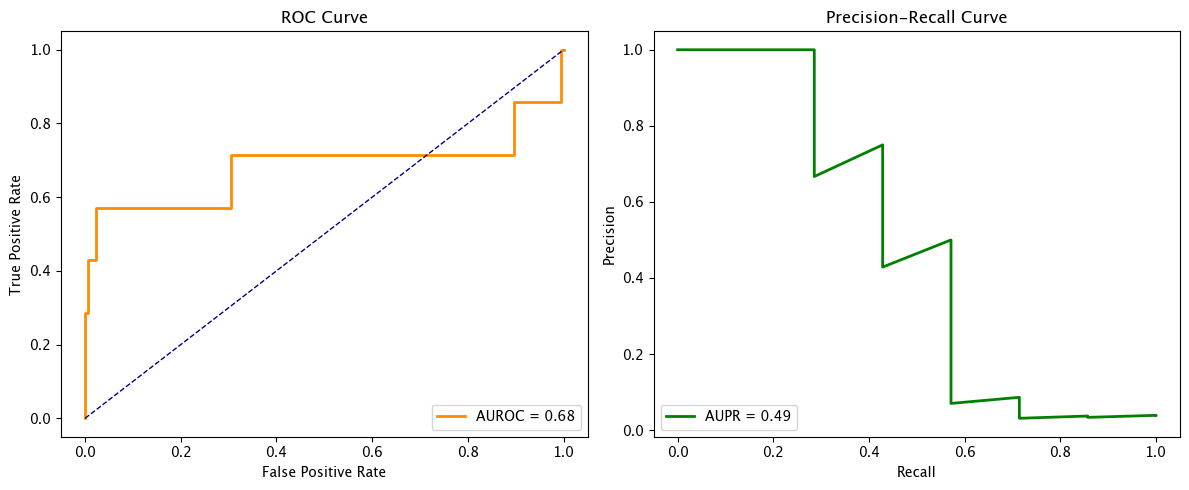

In [112]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score, average_precision_score

# Assuming your DataFrame is named df
y_true = over_CRISPRi_value['Significant']       # Boolean: True = positive class
y_scores = over_CRISPRi_value['Value']           # Prediction scores

# --- Compute ROC curve and AUC ---
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# --- Compute PR curve and AUC ---
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = average_precision_score(y_true, y_scores)

# --- Plot ROC curve ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUROC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# --- Plot PR curve ---
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2, label=f'AUPR = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

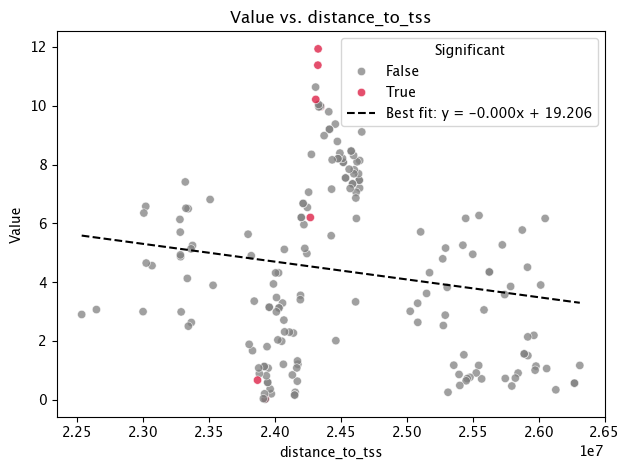

In [119]:
plot_values(over_CRISPRi_value, x_col="distance_to_tss", y_col= "Value", hue_col="Significant", line_fit=True)

In [ ]:
def CRISPRi_label_transfer(A, B, A_label = ['chr', 'start', 'end'], B_label = ['chr', 'start', 'end'] ):
    
    A_chr = A[A_label].copy()
    B_chr= B[B_label].copy()
    
    A_str = A_chr.to_csv(sep="\t", header=False, index=False)
    B_str = B_chr.to_csv(sep="\t", header=False, index=False)

    A_bed = pybedtools.BedTool(A_str, from_string=True)
    B_bed = pybedtools.BedTool(B_str, from_string=True)

    # Intersect: returns TP CRIPSRi peaks that overlap with CLR peaks
    overlap =  A_bed.intersect(B_bed, wa=True)  

    # Convert result to DataFrame
    overlap_df = overlap.to_dataframe(names=["chr", "start", "end"])
    overlap_df[["start", "end"]] = overlap_df[["start", "end"]].astype(int)
    
    
    
    return overlap_df



def CRISPRi_comparison(A, B):
    
    A_str = A.to_csv(sep="\t", header=False, index=False)
    B_str = B.to_csv(sep="\t", header=False, index=False)

    A_bed = pybedtools.BedTool(A_str, from_string=True)
    B_bed = pybedtools.BedTool(B_str, from_string=True)

    # Intersect: returns TP CRIPSRi peaks that overlap with CLR peaks
    overlap =  A_bed.intersect(B_bed, wa=True)  

    # Convert result to DataFrame
    overlap_df = overlap.to_dataframe(names=["chr", "start", "end"])
    overlap_df[["start", "end"]] = overlap_df[["start", "end"]].astype(int)
    
    return overlap_df


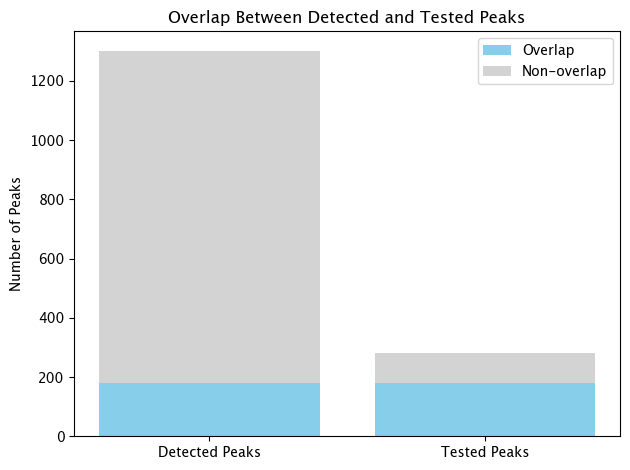

In [14]:
import matplotlib.pyplot as plt

# Example data — replace these with your actual values
total_detected = 1302
total_tested = 280
overlap = 181

# Calculate non-overlap values
detected_non_overlap = total_detected - overlap
tested_non_overlap = total_tested - overlap

# Create stacked bars
fig, ax = plt.subplots()

bars = ['Detected Peaks', 'Tested Peaks']
overlaps = [overlap, overlap]
non_overlaps = [detected_non_overlap, tested_non_overlap]

ax.bar(bars, overlaps, label='Overlap', color='skyblue')
ax.bar(bars, non_overlaps, bottom=overlaps, label='Non-overlap', color='lightgray')

# Add labels and legend
ax.set_ylabel('Number of Peaks')
ax.set_title('Overlap Between Detected and Tested Peaks')
ax.legend()

plt.tight_layout()
plt.show()

# Run CRISPRi comparison

In [ ]:
# Read CRISPRi data

CRISPRi_data = pd.read_excel('/Users/alexandra/Desktop/Data/CRISPRiFlowFISH/41588_2019_538_MOESM3_ESM.xlsx',
                             sheet_name='Supplementary Table 3a', 
                             skiprows=1,
                             header=1)

# Find GATA1 
CRISPRi_GATA1 = CRISPRi_data[CRISPRi_data['Gene'] == 'GATA1'].copy()
CRISPRi_GATA1 = CRISPRi_GATA1[['chr', 'start', 'end', 'class', 'Significant','Gene']].copy()

CRISPRi_GATA1


# Read MI matrix
with open('/Users/alexandra/Desktop/EG-CLR/Test/results/ChrX_SelectGenes_AllPeaks_NormByCell.pkl', 'rb') as file:
    MI_Matrix = pickle.load(file)
    
CLR_matrix = CLR_Matrix(MI_Matrix)
CLR_matrix = pd.DataFrame(CLR_matrix.values, index=MI_Matrix.index, columns=MI_Matrix.columns)

In [ ]:
CLR_matrix = pd.DataFrame(CLR_matrix.values, index=MI_Matrix.index, columns=MI_Matrix.columns)

In [ ]:
# for GATA1

# obtain GATA1 peaks
GATA1_MI = EG_pair_by_name("GATA1", CLR_matrix)

# select peaks
GATA1_MI_limited = select_testing_peaks(CRISPRi_GATA1,GATA1_MI)
CRISPRi_GATA1_limited = select_testing_peaks(GATA1_MI_limited, CRISPRi_GATA1)

# select TP
CRISPRi_TP = CRISPRi_GATA1_limited[CRISPRi_GATA1_limited['Significant'] == True].copy()
CRISPRi_TP = CRISPRi_TP[['chr', 'start', 'end']].copy()

# overlap TP with prediction
overlap_df = CRISPRi_comparison(GATA1_MI_limited[['chr', 'start', 'end']].copy(),CRISPRi_TP)


# obtain GATA1 MI values
merge_df = pd.merge(overlap_df, GATA1_MI_limited, on=['chr', 'start', 'end'], how='left')
merge_df

In [ ]:
CRISPRi_TP, merge_df, CRISPRi_peaks_limited, Gene_peaks_limited = CRISPRi_TP_comparison("GATA1", CLR_matrix, CRISPRi_data)

In [ ]:
# Given a gene's name, CLR matrix and CRISPRi return the comparison of the predicted peaks and the CRISPRi TP peaks.
def CRISPRi_TP_comparison(gene_name, CLR_matrix, CRISPRi_data):
    
    # Find gene ATAC peaks
    Gene_peaks = EG_pair_by_name(gene_name, CLR_matrix)

    # Find CRISPRi peaks
    CRISPRi_peaks = CRISPRi_data[CRISPRi_data['Gene'] == gene_name].copy()
    CRISPRi_peaks = CRISPRi_peaks[['chr', 'start', 'end', 'class', 'Significant','Gene']].copy()

    # select peaks
    Gene_peaks_limited = select_testing_peaks(CRISPRi_peaks,Gene_peaks)
    CRISPRi_peaks_limited = find_detected_peaks(Gene_peaks_limited, CRISPRi_peaks)

    # select TP
    CRISPRi_TP = CRISPRi_peaks_limited[CRISPRi_peaks_limited['Significant'] == True].copy()
    CRISPRi_TP = CRISPRi_TP[['chr', 'start', 'end']].copy()

    # overlap TP with prediction
    overlap_df = CRISPRi_comparison(Gene_peaks_limited[['chr', 'start', 'end']].copy(),CRISPRi_TP)

    # obtain GATA1 MI values
    merge_df = pd.merge(overlap_df, Gene_peaks_limited, on=['chr', 'start', 'end'], how='left')
    merge_df
    
    return CRISPRi_TP, merge_df, CRISPRi_peaks_limited, Gene_peaks_limited
        

In [ ]:
with open('/Users/alexandra/Desktop/EG-CLR/SingleCellDataAnalysis/K562/10X_multiomics/Analysis_Pipeline/results/ChrX_SelectGenes_AllPeaks_NormByCell.pkl', 'rb') as file:
    MI_Matrix = pickle.load(file)
CLR_matrix = CLR_Matrix(MI_Matrix)
CLR_matrix = pd.DataFrame(CLR_matrix.values, index=MI_Matrix.index, columns=MI_Matrix.columns)

In [ ]:
# for GATA1

# obtain GATA1 peaks
GATA1_MI = EG_pair_by_name("GATA1", CLR_matrix)

# select peaks
GATA1_MI_limited = select_testing_peaks(CRISPRi_GATA1,GATA1_MI)
CRISPRi_GATA1_limited = select_testing_peaks(GATA1_MI_limited, CRISPRi_GATA1)

In [ ]:


# select TP
CRISPRi_TP = CRISPRi_GATA1_limited[CRISPRi_GATA1_limited['Significant'] == True].copy()
CRISPRi_TP = CRISPRi_TP[['chr', 'start', 'end']].copy()

# overlap TP with prediction
overlap_df = CRISPRi_comparison(GATA1_MI_limited[['chr', 'start', 'end']].copy(),CRISPRi_TP)


# obtain GATA1 MI values
merge_df = pd.merge(overlap_df, GATA1_MI_limited, on=['chr', 'start', 'end'], how='left')
merge_df  

In [ ]:
import matplotlib.pyplot as plt
import anndata as ad
import seaborn as sns

In [ ]:
CLR_Matrix

In [ ]:
CLR_Matrix["GATA1"]

In [ ]:
CLR_Matrix 

In [ ]:
GATA1_MI = CLR_Matrix["GATA1"].copy()

plt.figure()
sns.histplot(GATA1_MI, kde=True, stat='density', bins='auto', edgecolor='white')
plt.title('Sample distribution (histogram + KDE)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.tight_layout()